# CSV preprocessing

**Author:** Óscar García Hinde\
**E-Mail:** oghinde@gmail.com

This is a simple notebook that will perform a series of basic preliminary preprocessing steps on a given csv file.
Specifically, it will:
- Display basic info o the dataset.
- Drop features with a large proportion of missing values.
- Identify potential categorical features and one-hot encode them.
- Generate plots for main feature types.
- Display the feature correlation matrix and identify highly correlated feature pairs. 

It also defines a couple of simple functions to create datetime indexes and plot feature combinations.

The `data/` directory contains a couple of sample datasets.

*This is a work in progress*.

In [1]:
# Import some useful libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Map drawing library
import cartopy.crs as ccrs
mapTile = 1 # 0 = open_street_map, 1 = GoogleTiles
if mapTile:
    from cartopy.io.img_tiles import GoogleTiles as OSM
else:
    from cartopy.io.img_tiles import OSM

# Preset plot font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def convert_datetime(df, col_name, date_format, make_index=False):
    '''
    Convert a specific column to datetime type following a specified format
    and set it as idex column if requested.
    '''
    
    # Convert Date column to datetime format
    df[col_name] = pd.to_datetime(df[col_name], format=date_format)
    if make_index:
        # Set date column as index
        df.set_index(col_name, inplace=True)
        
    return df

def plot_two_feats(df, feat1, feat2, save=False):
    
    # Group by the requested columns
    dfg = df.groupby([feat1, feat2])
    df_aux = dfg.size().unstack()
    
    fig, ax = plt.subplots()
    ax = df_aux.plot(kind='bar', stacked=True, width=.5, ax=ax)
    ax.tick_params(axis='x', labelrotation = 45)
    plt.show()
    
    return fig

# Define preprocessing parameters
max_cols = 25      # max number of columns to display
drop_nans = True   # if True drop high nan ratio features
nan_thr = 0.8      # nan ratio threshold for feature drop
cat_thr = 10       # number of instances to consider a feature as categorical
corr_thr = 0.8    # high feature correlation threshold
one_hot = True     # one-hot encode categorical features
plt_bool = True    # plot histograms for boolean fetures
plt_num = True     # plot histograms for numerical fetures
plt_cat = True     # plot histograms for categorical fetures
store_figs = True  # store figures if True
demos = False      # demonstrate aux functions (only on squirrel dataset)

# Specify path to csv and keyword descriptor
#path = 'data/2018_Central_Park_Squirrel_Census.csv'
path = 'data/Iris.csv'
descr = 'Iris' # a simple keyword to describe the dataset

In [2]:
# Setup folders
fig_path = descr+'_figures/'
if store_figs:
    try:
        os.mkdir(fig_path)
    except OSError as e:
        print(f"Creation of the directory '{fig_path}' failed.")
        print(e)
    else:
        print(f"Successfully created the directory {fig_path}.")

# Load data onto a dataframe, show info
print('\nDataset summary:\n')
df = pd.read_csv(path)
df.info()

Creation of the directory 'Iris_figures/' failed.
[WinError 183] No se puede crear un archivo que ya existe: 'Iris_figures/'

Dataset summary:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [3]:
# Get a little more info
N, D = df.shape
feat_names = df.columns
feat_types = df.dtypes
feat_nan_flag = [df[col].isnull().values.any() for col in feat_names]
feat_nan_ratio = np.array([df[col].isnull().sum()/N for col in feat_names])

print(f'\nMissing value rates:')
for feat in zip(feat_names, feat_nan_ratio):
    print(f'- "{feat[0]}", NaN ratio = {feat[1]}')

df.head()
print(feat_names)


Missing value rates:
- "Id", NaN ratio = 0.0
- "SepalLengthCm", NaN ratio = 0.0
- "SepalWidthCm", NaN ratio = 0.0
- "PetalLengthCm", NaN ratio = 0.0
- "PetalWidthCm", NaN ratio = 0.0
- "Species", NaN ratio = 0.0
Index(['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')


In [4]:
# Drop high nan ratio features
if drop_nans:
    drop_feats = feat_names[feat_nan_ratio >= nan_thr]
    print('\nDropping the following columns:')
    for i in drop_feats:
        print(f'  - {i}')
    df = df.drop(columns=drop_feats)


Dropping the following columns:


In [5]:
# Identify potential categorical features
likely = [] 
unsure = []
unlikely = []
for name in df.select_dtypes(include='object').columns:
    counts = df[name].value_counts().values
    if counts.max() >= cat_thr:
        likely.append(name)
        df[name] = df[name].astype('category')
    elif 3 < counts.max() < cat_thr:
        unsure.append(name)
        df[name] = df[name].astype('category')
    else:
        unlikely.append(name)
feat_types = df.dtypes # update feat_types
print('The following features are likely to be categorical and have been converted:')
for name in likely: print(f'  - {name}')
print('\nThe following features might be categorical and have been converted:')
for name in unsure: print(f'  - {name}')
print('\nThe following features are unlikely to be categorical:')
for name in unlikely: print(f'  - {name}')

The following features are likely to be categorical and have been converted:
  - Species

The following features might be categorical and have been converted:

The following features are unlikely to be categorical:


In [6]:
# Bar plots for boolean variables
if plt_bool and 'bool' in feat_types.values:
    for name in df.select_dtypes(include='bool').columns:
        fig, ax = plt.subplots(nrows=1, figsize=(5, 3))
        ax = df[name].value_counts().plot(kind='bar', ax=ax)
        ax.tick_params(axis='x', labelrotation = 0)
        ax.set_title(name)
        if store_figs:
            fig.savefig(fig_path+f'{name}.png')

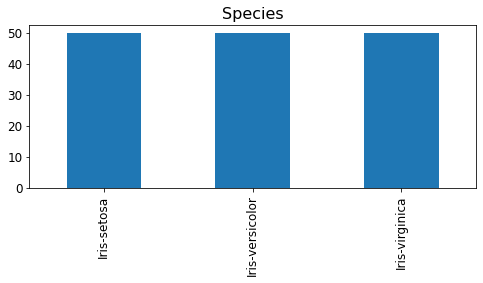

In [7]:
# Bar plots for categorical variables
if plt_cat:
    for name in df.select_dtypes(include='category').columns:
        fig, ax = plt.subplots(nrows=1, figsize=(8, 3))
        ax = df[name].value_counts().plot(kind='bar', ax=ax)
        ax.tick_params(axis='x', labelrotation = 90)
        ax.set_title(name)
        if store_figs:
            fig.savefig(fig_path+f'{name}.png')

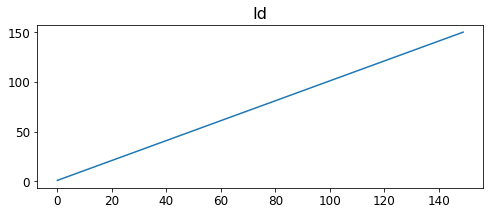

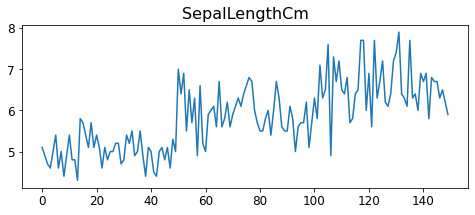

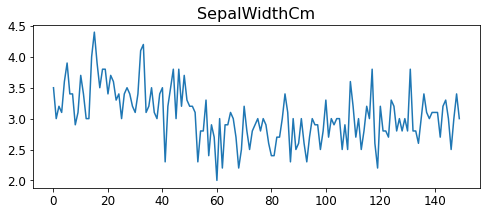

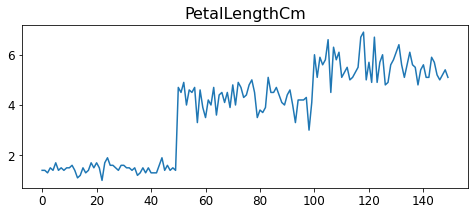

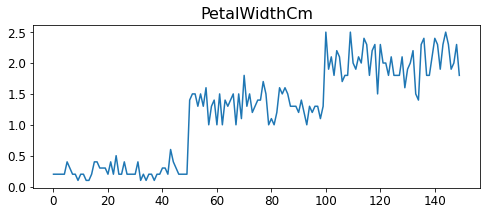

In [8]:
# Plots for numerical variables
if plt_num:
    for name in df.select_dtypes(include=[np.number]).columns:
        fig, ax = plt.subplots(nrows=1, figsize=(8, 3))
        ax = df[name].plot(ax=ax)
        ax.set_title(name)
        if store_figs:
            fig.savefig(fig_path+f'{name}.png')

In [9]:
if demos:
    # Example of 'convert_datetime' usage
    df = convert_datetime(df, 'Date', '%m%d%Y')
    feat_types = df.dtypes # update feat_types
    df.info()

    # Examples of 'plot_two_feats' usage
    # Date & shift
    fig = plot_two_feats(df, df['Date'].dt.date, 'Shift')
    if store_figs:
        fig.savefig(fig_path+f'date_shift.png')

    # Fur color and age
    fig = plot_two_feats(df, 'Primary Fur Color', 'Age')
    if store_figs:
        fig.savefig(fig_path+f'fur_age.png')

In [10]:
# One-hot encode categorical features
if one_hot:
    for name in df.select_dtypes(include='category').columns:
        y = pd.get_dummies(df[name], prefix=name)
        # Replace cat feature with encoded columns
        df = df.drop(columns=[name])
        df = df.join(y)
# Update feature names
feat_names = df.columns

High correlation columns:
('Id', 'PetalLengthCm')
('Id', 'PetalWidthCm')
('Id', 'Species_Iris-setosa')
('Id', 'Species_Iris-virginica')
('SepalLengthCm', 'PetalLengthCm')
('SepalLengthCm', 'PetalWidthCm')
('PetalLengthCm', 'PetalWidthCm')
('PetalLengthCm', 'Species_Iris-setosa')
('PetalWidthCm', 'Species_Iris-setosa')


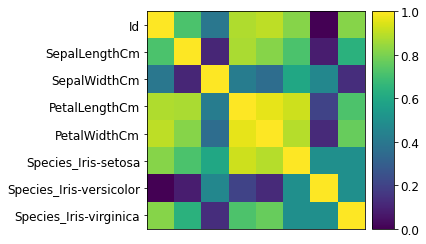

In [11]:
# Feature correlation matrix
corr_matrix = df.corr().abs()
upper_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
idx = np.where(upper_matrix.to_numpy() > corr_thr)
high_corr_cols = [pair for pair in zip(df.columns[idx[0]], df.columns[idx[1]])]

fig, ax = plt.subplots()
im = ax.imshow(corr_matrix)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.set_yticks(range(len(df.columns)))
ax.set_yticklabels(df.columns)
# Make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)
fig.colorbar(im, cax=cax)
fig.savefig(fig_path+'corr_matrix')

print('High correlation columns:')
for pair in high_corr_cols:
    print(pair)

In [12]:
# Save preprocessed dataframe to pickle file
save_file = descr+'_clean.pkl'
df.to_pickle(save_file)